In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor

In [2]:
energydata = pd.DataFrame.from_csv('../energydata_complete.csv', index_col=None, encoding="utf-8")
energydata["date"] = pd.to_datetime(energydata.date)
energydata["consumedE"] = energydata["Appliances"]+energydata["lights"]
energydata = energydata[(energydata.date>=pd.to_datetime("2016-01-12")) & (energydata.date<pd.to_datetime("2016-05-27"))]
energydata.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,consumedE
count,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,...,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000,19584.000000
mean,97.396344,3.763276,21.673039,40.212379,20.319462,40.394346,22.245344,39.219290,20.837798,38.983193,...,41.518732,7.360404,755.564782,79.760442,4.046492,38.279437,3.712474,24.983413,24.983413,101.159620
std,102.276678,7.842493,1.597255,3.954105,2.176298,4.070266,1.977770,3.248381,2.030943,4.325417,...,4.149146,5.279851,7.367592,14.917120,2.453617,11.756823,4.161938,14.500737,14.500737,104.114204
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,10.000000
25%,50.000000,0.000000,20.730000,37.326667,18.790000,37.863333,20.790000,36.884286,19.500000,35.500000,...,38.500000,3.633333,750.933333,70.333333,2.000000,29.000000,0.900000,12.486373,12.486373,50.000000
50%,60.000000,0.000000,21.600000,39.590000,20.000000,40.466667,22.100000,38.500000,20.633333,38.400000,...,40.837857,6.900000,756.116667,83.666667,3.666667,40.000000,3.400000,24.891900,24.891900,60.000000
75%,100.000000,0.000000,22.600000,42.966667,21.500000,43.210714,23.290000,41.730000,22.100000,42.030000,...,44.252071,10.350000,761.000000,91.666667,5.500000,40.000000,6.500000,37.586778,37.586778,100.000000
max,1080.000000,50.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530,1110.000000


In [3]:
energydata.head(1)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,consumedE
42,2016-01-12,40,10,21.39,44.56,20.79,43.863333,20.2,45.663333,20.633333,...,45.7,5.3,736.9,92.0,6.0,22.0,4.1,39.146638,39.146638,50


### Number of features

In [4]:
len(energydata.columns)

30

# Change in granularity

In [5]:
dfdate = energydata.set_index("date")
dfdate = dfdate.resample('H').mean()
dfdate = dfdate.drop(["Appliances","lights"], axis = 1)
dfdate.describe()

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,consumedE
count,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,...,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000
mean,21.673039,40.212379,20.319462,40.394346,22.245344,39.219290,20.837798,38.983193,19.578744,50.913567,...,41.518732,7.360404,755.564782,79.760442,4.046492,38.279437,3.712474,24.983413,24.983413,101.159620
std,1.596212,3.916452,2.171841,4.054460,1.975911,3.238923,2.028330,4.320139,1.831218,8.646427,...,4.140844,5.273695,7.367658,14.843258,2.433606,11.170744,4.157021,5.951300,5.951300,83.020902
min,16.790000,27.509167,16.100000,21.010000,17.245000,29.700556,15.100000,28.715571,15.347500,30.188611,...,29.218889,-4.961111,729.383333,25.250000,0.416667,1.000000,-6.475000,5.259551,5.259551,28.333333
25%,20.740556,37.320972,18.817222,37.892326,20.790000,36.865228,19.544444,35.500156,18.259931,45.451944,...,38.500000,3.647917,750.916667,70.479167,2.000000,31.833333,0.906250,20.734102,20.734102,51.666667
50%,21.590278,39.606944,19.968333,40.467424,22.100000,38.515278,20.638889,38.381343,19.383095,49.161759,...,40.806944,6.887500,756.141667,83.666667,3.583333,40.000000,3.391667,24.943998,24.943998,66.666667
75%,22.611111,43.015660,21.470417,43.227333,23.290000,41.740556,22.089167,42.006215,20.607609,53.822106,...,44.250625,10.370833,760.983333,91.583333,5.416667,40.000000,6.485417,29.101986,29.101986,116.666667
max,26.203333,53.980139,29.727778,53.914975,28.975286,49.472222,26.144762,50.747222,25.506389,94.884074,...,53.140000,25.933333,772.258333,100.000000,13.000000,66.000000,15.250000,43.611051,43.611051,623.333333


In [6]:
dfdate.head(2)

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,consumedE
date,,,,,,,,,,,,,,,,,,,,,
2016-01-12 00:00:00,21.266111,44.960556,20.637222,44.018333,20.144444,45.542222,20.514444,47.112778,19.155556,50.396111,...,45.875000,5.216667,737.150000,92.0,6.000000,29.5,4.016667,26.296718,26.296718,158.333333
2016-01-12 01:00:00,20.963611,45.613194,20.333333,44.273333,20.133333,45.540000,21.505556,46.946667,18.969444,50.076111,...,46.307778,5.141667,737.833333,92.0,5.583333,40.0,3.941667,28.723073,28.723073,176.666667


# Feature Reduction
## mutual_info

In [18]:
midate = mutual_info_regression(dfdate.loc[:, dfdate.columns != 'consumedE'], dfdate.consumedE)
midate /= np.max(midate)
mean_midate = sum(midate)/len(midate)
mean_midate

0.70111892475735615

In [19]:
midatefeatures = pd.DataFrame(list(zip(dfdate.loc[:, dfdate.columns != 'consumedE'], midate)), columns = ["name", 'miCoefficient'])
midatefeatures[midatefeatures.miCoefficient > mean_midate]

,name,miCoefficient
0,T1,0.745065
3,T3,0.801466
5,T4,0.813697
7,T5,0.811541
9,T7,0.853730
10,T8,0.841512
11,T9,1.000000


In [20]:
midatefeatures = midatefeatures[midatefeatures.miCoefficient < mean_midate]
dfdate = dfdate.drop(list(midatefeatures.name.values), axis = 1)
dfdate = np.log(dfdate)
dfdate.describe()

,T1,T3,T4,T5,T7,T8,T9,consumedE
count,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000
mean,1.122478,1.130433,1.108706,1.088142,1.098990,1.127134,1.085874,1.470776
std,0.024095,0.028349,0.032344,0.030872,0.034406,0.029519,0.034350,0.134267
min,1.037015,1.046449,0.998680,1.004650,1.006146,1.027864,0.993507,1.207179
25%,1.109252,1.110037,1.089468,1.066333,1.074742,1.110000,1.061812,1.372402
50%,1.122408,1.129975,1.107631,1.086675,1.097768,1.130453,1.086795,1.435014
75%,1.137333,1.146775,1.129816,1.107129,1.122554,1.147803,1.106650,1.560105
max,1.183531,1.213857,1.182846,1.175243,1.180276,1.194761,1.162736,1.861764


### Number of features

In [21]:
len(dfdate.columns)

8

here I have to load the forecast_energy.csv

# Creating big matrices

In [22]:
def RF_1timeseries(X,y):
    #model random forest
    model = RandomForestRegressor(n_estimators=50,criterion="mae",max_depth=4,random_state=1,n_jobs=-1)
    model.fit( X , y )
    
    newXarray = np.append( np.delete(X.iloc[-1].values,0), (y[-1]) )
    newXarray = np.reshape( newXarray, (1,len(newXarray)))
    
    newX = pd.DataFrame( newXarray, columns=X.columns.values )
    newX["date"] = pd.Series(pd.date_range(X.index[-1]+pd.to_timedelta(1, unit='h'), periods=1, freq='H'))
    newX = newX.set_index("date")
    
    newy = model.predict(newX)
    
    return(newX,newy)

In [23]:
bigdf = pd.DataFrame()
for column in dfdate.columns.values:
    for i in range(24,0,-1):
        bigdf[str(column)+"t-"+str(i)] = dfdate[str(column)].shift(i)
    bigdf[str(column)] = dfdate[str(column)]
bigdf = bigdf.dropna()

In [24]:
table_names = []
for column in dfdate.loc[:,dfdate.columns != 'consumedE'].columns.values:
    globals()['bigdf%s' % column] = bigdf.loc[:,bigdf.columns.str.contains(str(column))]
    table_names.append('bigdf%s' % column)

# here is the important part

In [ ]:
forecast = pd.DataFrame()
for name in table_names:
    X = globals()[name].loc[ :, globals()[name].columns != globals()[name].columns[-1] ]
    y = globals()[name].iloc[:,-1]
    newX, newy = RF_1timeseries(X,y)
    newX[globals()[name].columns[-1]] = newy
    globals()[name] = globals()[name].append(newX)
    forecast = pd.concat([forecast,newX ], axis=1)

bigmodel = RandomForestRegressor(n_estimators=50,criterion="mae",max_depth=4,random_state=1,n_jobs=-1)
bigmodel.fit( bigdf.loc[:, bigdf.columns != 'consumedE'] , bigdf.consumedE )

conEarray = np.delete(bigdf.loc[:,bigdf.columns.str.contains("consumed",na=True)].iloc[-1].values,0)
conEarray = np.reshape(conEarray,(1,len(conEarray)))
conEcolumns = bigdf.loc[:,(bigdf.columns.str.contains("consumed",na=True)) & (bigdf.columns != 'consumedE')].columns.values
conE = pd.DataFrame( conEarray, columns=conEcolumns )
conE["date"] = pd.Series(pd.date_range(bigdf.index[-1]+pd.to_timedelta(1, unit='h'), periods=1, freq='H'))
conE = conE.set_index("date")

forecast = pd.concat([forecast,conE], axis=1)
conEy = bigmodel.predict(forecast)
forecast["consumedE"] = conEy
bigdf = bigdf.append(forecast)

In [99]:
bigdf.to_csv("forecast_energy.csv")

In [100]:
bigdf

,T1t-24,T1t-23,T1t-22,T1t-21,T1t-20,T1t-19,T1t-18,T1t-17,T1t-16,T1t-15,...,consumedEt-9,consumedEt-8,consumedEt-7,consumedEt-6,consumedEt-5,consumedEt-4,consumedEt-3,consumedEt-2,consumedEt-1,consumedE
date,,,,,,,,,,,,,,,,,,,,,
2016-01-13 00:00:00,1.117472,1.112774,1.108554,1.104787,1.100989,1.097837,1.095449,1.093941,1.094785,1.093508,...,1.281453,1.305323,1.699949,1.462674,1.388126,1.372402,1.346261,1.355351,1.326789,1.239899
2016-01-13 01:00:00,1.112774,1.108554,1.104787,1.100989,1.097837,1.095449,1.093941,1.094785,1.093508,1.093546,...,1.305323,1.699949,1.462674,1.388126,1.372402,1.346261,1.355351,1.326789,1.239899,1.355351
2016-01-13 02:00:00,1.108554,1.104787,1.100989,1.097837,1.095449,1.093941,1.094785,1.093508,1.093546,1.096883,...,1.699949,1.462674,1.388126,1.372402,1.346261,1.355351,1.326789,1.239899,1.355351,1.336753
2016-01-13 03:00:00,1.104787,1.100989,1.097837,1.095449,1.093941,1.094785,1.093508,1.093546,1.096883,1.098391,...,1.462674,1.388126,1.372402,1.346261,1.355351,1.326789,1.239899,1.355351,1.336753,1.239899
2016-01-13 04:00:00,1.100989,1.097837,1.095449,1.093941,1.094785,1.093508,1.093546,1.096883,1.098391,1.098391,...,1.388126,1.372402,1.346261,1.355351,1.326789,1.239899,1.355351,1.336753,1.239899,1.336753
2016-01-13 05:00:00,1.097837,1.095449,1.093941,1.094785,1.093508,1.093546,1.096883,1.098391,1.098391,1.097189,...,1.372402,1.346261,1.355351,1.326789,1.239899,1.355351,1.336753,1.239899,1.336753,1.316328
2016-01-13 06:00:00,1.095449,1.093941,1.094785,1.093508,1.093546,1.096883,1.098391,1.098391,1.097189,1.097170,...,1.346261,1.355351,1.326789,1.239899,1.355351,1.336753,1.239899,1.336753,1.316328,1.452088
2016-01-13 07:00:00,1.093941,1.094785,1.093508,1.093546,1.096883,1.098391,1.098391,1.097189,1.097170,1.098852,...,1.355351,1.326789,1.239899,1.355351,1.336753,1.239899,1.336753,1.316328,1.452088,1.435014
2016-01-13 08:00:00,1.094785,1.093508,1.093546,1.096883,1.098391,1.098391,1.097189,1.097170,1.098852,1.097559,...,1.326789,1.239899,1.355351,1.336753,1.239899,1.336753,1.316328,1.452088,1.435014,1.689376


# Feature reduction using random forest

In [17]:
model = RandomForestRegressor(n_estimators=2000,criterion="mae",max_features=3,max_depth=2,random_state=1,n_jobs=-1)
model.fit( bigdf.loc[:, bigdf.columns != 'consumedE'] , bigdf.consumedE)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=2,
           max_features=3, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

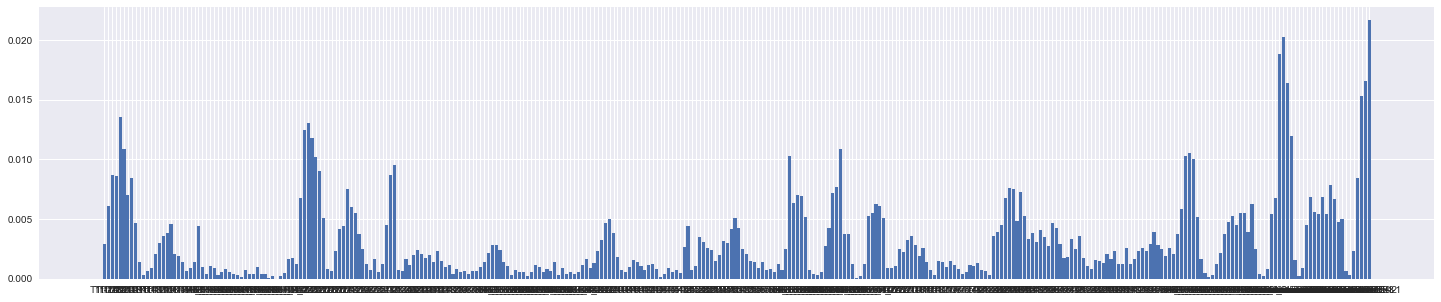

In [18]:
names = bigdf.loc[:, bigdf.columns != 'consumedE'].columns.values
ticks = [i for i in range(len(names))]
plt.figure(figsize=(25,5))
plt.bar(ticks, model.feature_importances_)
plt.xticks(ticks,names)
plt.show()

In [19]:
importance = pd.DataFrame()
importance["feature"] = names
importance["value"] = model.feature_importances_

In [20]:
importance

,feature,value
0,T1t-24,0.002909
1,T1t-23,0.006134
2,T1t-22,0.008718
3,T1t-21,0.008571
4,T1t-20,0.013544
5,T1t-19,0.010906
6,T1t-18,0.006987
7,T1t-17,0.008426
8,T1t-16,0.004654
9,T1t-15,0.001449


In [21]:
importance = importance[importance.value < importance.value.mean()]
bigdf = bigdf.drop(list(importance.feature.values), axis = 1)

In [22]:
model = RandomForestRegressor(n_estimators=2000,criterion="mae",max_features=3,max_depth=2,random_state=1,n_jobs=-1)
model.fit( bigdf.loc[:, bigdf.columns != 'consumedE'] , bigdf.consumedE)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=2,
           max_features=3, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

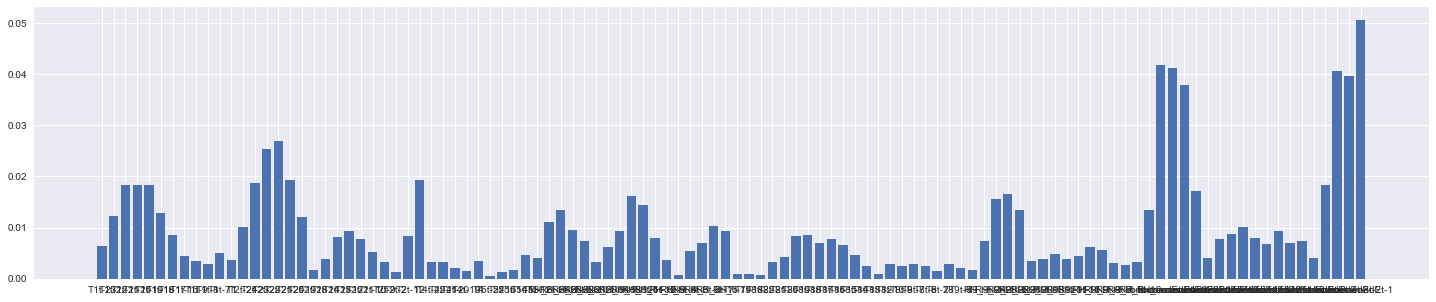

In [23]:
names = bigdf.loc[:, bigdf.columns != 'consumedE'].columns.values
ticks = [i for i in range(len(names))]
plt.figure(figsize=(25,5))
plt.bar(ticks, model.feature_importances_)
plt.xticks(ticks,names)
plt.show()

In [24]:
len(bigdf.columns)

109

In [23]:
depth = 10
errorvalue = np.zeros((depth-1,2))
for d in range(1,depth):
    y = pd.DataFrame()
    y["consumedE"] = bigdf.consumedE
    model = RandomForestRegressor(n_estimators=50,criterion="mae",max_depth=d,random_state=1,n_jobs=-1)
    model.fit( bigdf.loc[:, bigdf.columns != 'consumedE'] , bigdf.consumedE)
    predicted = model.predict(bigdf.loc[:, bigdf.columns != 'consumedE'])
    y["fitted"] = predicted
    y["error"] = np.abs(y.fitted - y.consumedE)/y.consumedE
    errorvalue[d-1,0] = int(d)
    errorvalue[d-1,1] = y.error.mean()*100

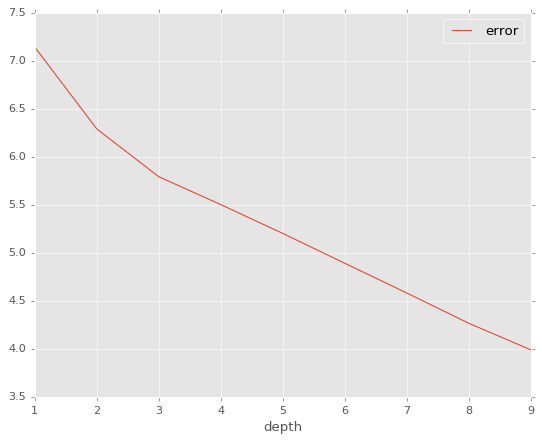

In [24]:
errorplt = pd.DataFrame(errorvalue,columns=["depth","error"])
errorplt = errorplt.set_index("depth")
plt.style.use('ggplot')
errorplt.plot()

In [25]:
dfdate.tail(2)

,T1,RH_1,T2,T3,RH_3,T4,T5,RH_6,T7,T8,T9,RH_9,consumedE
date,,,,,,,,,,,,,
2016-05-26 22:00:00,3.198673,3.798332,3.163192,3.287469,3.649821,3.205903,3.120405,2.870925,3.191417,3.207343,3.121385,3.793940,4.499810
2016-05-26 23:00:00,3.195425,3.796724,3.148748,3.285225,3.661023,3.210597,3.116966,3.097737,3.190065,3.201164,3.118441,3.795464,4.422849


In [25]:
from sklearn.model_selection import TimeSeriesSplit

In [45]:
final_test = bigdf.reset_index()
final_test.date = pd.to_datetime(final_test.date)
final_test = final_test[final_test.date >= pd.to_datetime("2016-05-26")]
final_test = final_test.set_index("date")

train_set = bigdf.reset_index()
train_set.date = pd.to_datetime(train_set.date)
train_set = train_set[train_set.date < pd.to_datetime("2016-05-26")]
train_set = train_set.set_index("date")

In [46]:
train_set.tail()

,T1t-23,T1t-22,T1t-21,T1t-20,T1t-19,T1t-18,T1t-17,T1t-16,T1t-9,T1t-8,...,consumedEt-12,consumedEt-11,consumedEt-10,consumedEt-9,consumedEt-8,consumedEt-4,consumedEt-3,consumedEt-2,consumedEt-1,consumedE
date,,,,,,,,,,,,,,,,,,,,,
2016-05-25 19:00:00,3.206803,3.203198,3.199081,3.191687,3.186536,3.181059,3.177290,3.170665,3.152831,3.152309,...,4.199705,4.653960,4.730333,4.462069,3.912023,4.382027,5.445300,4.773506,5.054120,4.773506
2016-05-25 20:00:00,3.203198,3.199081,3.191687,3.186536,3.181059,3.177290,3.170665,3.165428,3.152309,3.154397,...,4.653960,4.730333,4.462069,3.912023,4.094345,5.445300,4.773506,5.054120,4.773506,5.255758
2016-05-25 21:00:00,3.199081,3.191687,3.186536,3.181059,3.177290,3.170665,3.165428,3.161717,3.154397,3.161717,...,4.730333,4.462069,3.912023,4.094345,4.272026,4.773506,5.054120,4.773506,5.255758,4.094345
2016-05-25 22:00:00,3.191687,3.186536,3.181059,3.177290,3.170665,3.165428,3.161717,3.156646,3.161717,3.170106,...,4.462069,3.912023,4.094345,4.272026,4.382027,5.054120,4.773506,5.255758,4.094345,3.976562
2016-05-25 23:00:00,3.186536,3.181059,3.177290,3.170665,3.165428,3.161717,3.156646,3.152309,3.170106,3.181751,...,3.912023,4.094345,4.272026,4.382027,4.382027,4.773506,5.255758,4.094345,3.976562,3.976562


In [47]:
final_test.tail()

,T1t-23,T1t-22,T1t-21,T1t-20,T1t-19,T1t-18,T1t-17,T1t-16,T1t-9,T1t-8,...,consumedEt-12,consumedEt-11,consumedEt-10,consumedEt-9,consumedEt-8,consumedEt-4,consumedEt-3,consumedEt-2,consumedEt-1,consumedE
date,,,,,,,,,,,,,,,,,,,,,
2016-05-26 19:00:00,3.193651,3.190770,3.187881,3.184983,3.182077,3.179163,3.176239,3.173308,3.161482,3.169756,...,4.605170,5.054120,5.622813,5.579730,5.501258,4.121744,6.207919,6.086775,5.370638,5.408665
2016-05-26 20:00:00,3.190770,3.187881,3.184983,3.182077,3.179163,3.176239,3.173308,3.170367,3.169756,3.179881,...,5.054120,5.622813,5.579730,5.501258,5.401175,6.207919,6.086775,5.370638,5.408665,4.669709
2016-05-26 21:00:00,3.187881,3.184983,3.182077,3.179163,3.176239,3.173308,3.170367,3.167418,3.179881,3.186353,...,5.622813,5.579730,5.501258,5.401175,4.339467,6.086775,5.370638,5.408665,4.669709,4.499810
2016-05-26 22:00:00,3.184983,3.182077,3.179163,3.176239,3.173308,3.170367,3.167418,3.164461,3.186353,3.186353,...,5.579730,5.501258,5.401175,4.339467,4.248495,5.370638,5.408665,4.669709,4.499810,4.499810
2016-05-26 23:00:00,3.182077,3.179163,3.176239,3.173308,3.170367,3.167418,3.164461,3.161742,3.186353,3.186353,...,5.501258,5.401175,4.339467,4.248495,4.121744,5.408665,4.669709,4.499810,4.499810,4.422849


In [48]:
len(final_test)

24

In [53]:
d = 4
model = RandomForestRegressor(n_estimators=50,criterion="mae",max_depth=d,random_state=1,n_jobs=-1)
model.fit( train_set.loc[:, train_set.columns != 'consumedE'] , train_set.consumedE )

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [54]:
predicted = model.predict(final_test.loc[:, final_test.columns != 'consumedE'])
y = pd.DataFrame()
y["consumedE"] = final_test.consumedE.values
y["fitted"] = predicted
y["error"] = np.abs(y.fitted - y.consumedE)/y.consumedE

In [55]:
y.error.mean()

0.06161260176504408

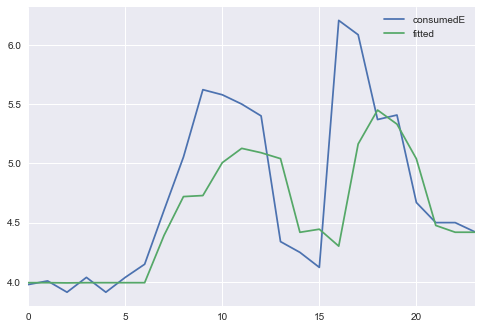

In [56]:
y[["consumedE","fitted"]].plot()

Index(['T1t-23', 'T1t-22', 'T1t-21', 'T1t-20', 'T1t-19', 'T1t-18', 'T1t-17',
       'T1t-16', 'T1t-9', 'T1t-8',
       ...
       'consumedEt-12', 'consumedEt-11', 'consumedEt-10', 'consumedEt-9',
       'consumedEt-8', 'consumedEt-4', 'consumedEt-3', 'consumedEt-2',
       'consumedEt-1', 'consumedE'],
      dtype='object', length=109)


In [36]:
tscv = TimeSeriesSplit( n_splits=int(len(train_set)/25) )
depth0 = 1
depth1 = 5
errors = []
for d in range(depth0,depth1):
    hypothesisresults = []
    split = 0
    for train, test in tscv.split(train_set):
        y = pd.DataFrame()
        model = RandomForestRegressor(n_estimators=50,criterion="mae",max_depth=d,random_state=1,n_jobs=-1)
        model.fit( train_set.loc[:, train_set.columns != 'consumedE'].iloc[train] , train_set.consumedE.iloc[train] )
        predicted = model.predict(train_set.loc[:, bigdf.columns != 'consumedE'].iloc[test])
        y["consumedE"] = bigdf.consumedE.iloc[test]
        y["fitted"] = predicted
        y["error"] = np.abs(y.fitted - y.consumedE)/y.consumedE
    hypothesisresults.append(y.error.mean())
    errors.append( hypothesisresults  )
print(len(test))

KeyboardInterrupt: 

In [32]:
errors= np.asarray(errors)
errors = pd.DataFrame(errors,columns=["error"])
errors.index +=1
errors[errors.error==errors.error.min()]

,error
1,0.088438


C:\Users\soloc\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


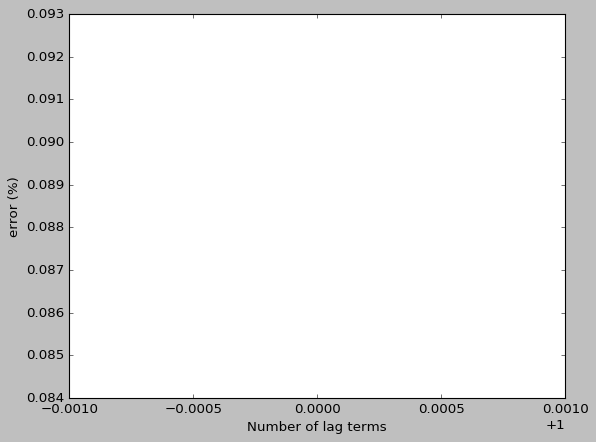

In [33]:
plt.style.use('classic')

errors.error = errors.error
ax = errors.plot(c="blue",legend=False)
ax.set_xlabel("Number of lag terms")
ax.set_ylabel("error (%)")
plt.savefig('error.eps', format='eps', dpi=1000)

In [35]:
errors

,error
1,0.088438
